# Sanity Check

# 0. Preparing

## Format the cell output

In [1]:
from IPython.core.display import HTML

HTML(
    """<style>div.output_area pre{white-space: pre;}</style>
    <script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>."""
)

## Create Spark Session on top of YARN

In [2]:
import pyspark

spark = (
    pyspark.sql.SparkSession.builder.appName("SanityCheck")
    .master("yarn")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.instances", "2")
    .getOrCreate()
)
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/15 00:04:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/15 00:04:29 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


## Load data from hdfs

In [3]:
df = spark.read.option("header", "true").csv(
    "hdfs://node-master:9000/user/hadoop/KAG_conversion_data.csv", inferSchema=True
)

## Quick look at the data

In [4]:
df.printSchema()
df.show()
df.count()

root
 |-- ad_id: integer (nullable = true)
 |-- xyz_campaign_id: integer (nullable = true)
 |-- fb_campaign_id: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- interest: integer (nullable = true)
 |-- Impressions: integer (nullable = true)
 |-- Clicks: integer (nullable = true)
 |-- Spent: double (nullable = true)
 |-- Total_Conversion: integer (nullable = true)
 |-- Approved_Conversion: integer (nullable = true)

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|
|70874

1143

# 1. Sanity Check

## Create a temp view for this session

In [5]:
df.select(
    "ad_id",
    "xyz_campaign_id",
    "fb_campaign_id",
    "age",
    "gender",
    "interest",
    "Impressions",
    "Clicks",
    "Spent",
    "Total_Conversion",
    "Approved_Conversion",
).createOrReplaceTempView("df")

## Check Missing 

In [6]:
from pyspark.sql.functions import isnan, when, count, col

df.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
).show()

+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+
|ad_id|xyz_campaign_id|fb_campaign_id|age|gender|interest|Impressions|Clicks|Spent|Total_Conversion|Approved_Conversion|
+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+
|    0|              0|             0|  0|     0|       0|          0|     0|    0|               0|                  0|
+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+



From the query, we found that the data contains no null/nan values

## Figure out the features
All the columns seems to be easy to understand from its definition, except for the column 'fb_campaign_id'. Let's figure out how they indexed this!

### fb_campaign_id

In [7]:
spark.sql("SELECT COUNT(DISTINCT fb_campaign_id) FROM df").show()

+------------------------------+
|count(DISTINCT fb_campaign_id)|
+------------------------------+
|                           691|
+------------------------------+



In [8]:
spark.sql(
    "SELECT xyz_campaign_id, fb_campaign_id, gender, age, interest, Spent FROM df WHERE fb_campaign_id IN \
            (SELECT fb_campaign_id FROM df GROUP BY fb_campaign_id HAVING COUNT(fb_campaign_id) > 1)"
).show()

+---------------+--------------+------+-----+--------+-----------+
|xyz_campaign_id|fb_campaign_id|gender|  age|interest|      Spent|
+---------------+--------------+------+-----+--------+-----------+
|            916|        103928|     M|30-34|      28|       1.25|
|            916|        103928|     M|30-34|      28|1.289999962|
|            916|        103965|     M|30-34|      16|        0.0|
|            916|        103965|     M|30-34|      16|        0.0|
|            916|        104012|     M|35-39|      15|        0.0|
|            916|        104012|     M|35-39|      15|2.609999895|
|            916|        104013|     M|35-39|      16|3.049999952|
|            916|        104013|     M|35-39|      16|3.059999943|
|            916|        104013|     M|35-39|      16|        0.0|
|            916|        104085|     M|40-44|      16|1.690000057|
|            916|        104085|     M|40-44|      16|        0.0|
|            916|        104205|     F|30-34|      16|        

We can see that, with similar fb_campaign_id, the xyz_id, gender, age, interest are the same, only the Spent is different. Hence, fb_cp_id might be the same campaign ad with the same group of customers but with different budget.

## Check outliers

### Spent

+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|  ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|1121100|           1178|        144532|30-34|     M|      15|    3052003|   340|639.9499981|              60|                 17|
|1121814|           1178|        144659|30-34|     F|      27|    2223278|   421|612.3000032|              38|                 13|
|1121601|           1178|        144624|45-49|     M|      16|    2286228|   353| 603.380002|              16|                  7|
|1122265|           1178|        144734|45-49|     F|      27|    1428421|   367|541.7000023|              10|                  0|
|1122193|           1178|        144722|45-49|     F|      10|    1358324|   346|46

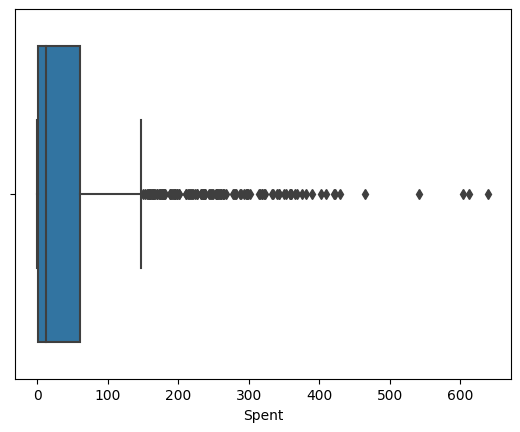

In [9]:
import seaborn as sns

sns.boxplot(x=df.toPandas()["Spent"])
df.sort(col("Spent").desc()).show()

### Impressions

+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|  ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|1121100|           1178|        144532|30-34|     M|      15|    3052003|   340|639.9499981|              60|                 17|
|1121601|           1178|        144624|45-49|     M|      16|    2286228|   353| 603.380002|              16|                  7|
|1121814|           1178|        144659|30-34|     F|      27|    2223278|   421|612.3000032|              38|                 13|
|1121104|           1178|        144533|30-34|     M|      16|    2080666|   202|360.1500015|              40|                 21|
|1121824|           1178|        144661|30-34|     F|      29|    1705246|   295|42

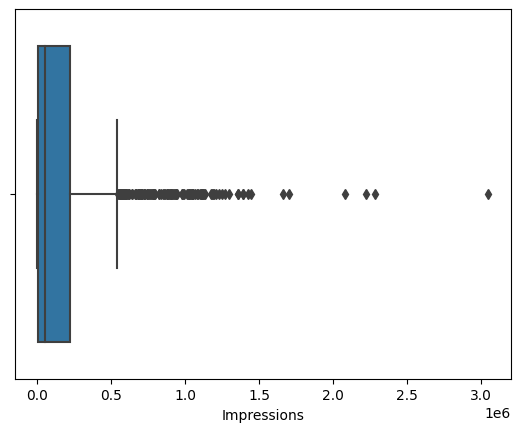

In [10]:
sns.boxplot(x=df.toPandas()["Impressions"])
df.sort(col("Impressions").desc()).show()

### Clicks

+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|  ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|1121814|           1178|        144659|30-34|     F|      27|    2223278|   421|612.3000032|              38|                 13|
|1122265|           1178|        144734|45-49|     F|      27|    1428421|   367|541.7000023|              10|                  0|
|1121601|           1178|        144624|45-49|     M|      16|    2286228|   353| 603.380002|              16|                  7|
|1122193|           1178|        144722|45-49|     F|      10|    1358324|   346|465.0799981|               8|                  2|
|1121100|           1178|        144532|30-34|     M|      15|    3052003|   340|63

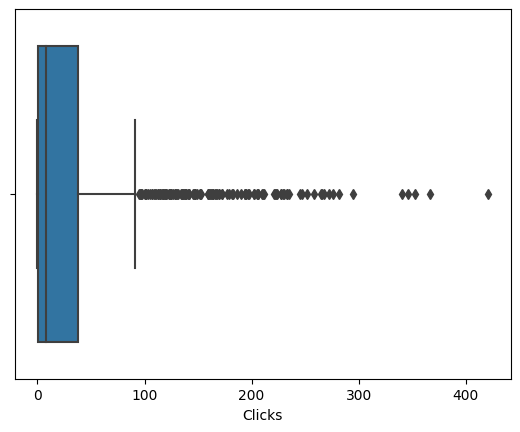

In [11]:
sns.boxplot(x=df.toPandas()["Clicks"])
df.sort(col("Clicks").desc()).show()

### Total_Conversion

+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|  ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|1121100|           1178|        144532|30-34|     M|      15|    3052003|   340|639.9499981|              60|                 17|
|1121104|           1178|        144533|30-34|     M|      16|    2080666|   202|360.1500015|              40|                 21|
|1121814|           1178|        144659|30-34|     F|      27|    2223278|   421|612.3000032|              38|                 13|
|1121196|           1178|        144552|30-34|     M|      28|    1392288|   206|358.5500029|              31|                  7|
|1314387|           1178|        179954|40-44|     F|     101|     696612|   152|22

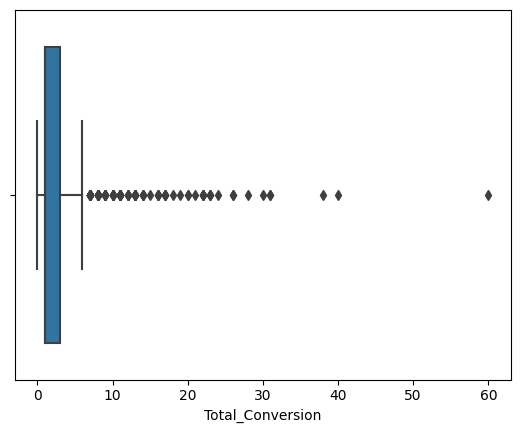

In [12]:
sns.boxplot(x=df.toPandas()["Total_Conversion"])
df.sort(col("Total_Conversion").desc()).show()

### Approved_Conversion

+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|  ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|1121104|           1178|        144533|30-34|     M|      16|    2080666|   202|360.1500015|              40|                 21|
|1121100|           1178|        144532|30-34|     M|      15|    3052003|   340|639.9499981|              60|                 17|
|1121091|           1178|        144531|30-34|     M|      10|    1194718|   141| 254.049996|              28|                 14|
|1121108|           1178|        144533|30-34|     M|      16|     984521|    95|163.8999972|              26|                 14|
|1121814|           1178|        144659|30-34|     F|      27|    2223278|   421|61

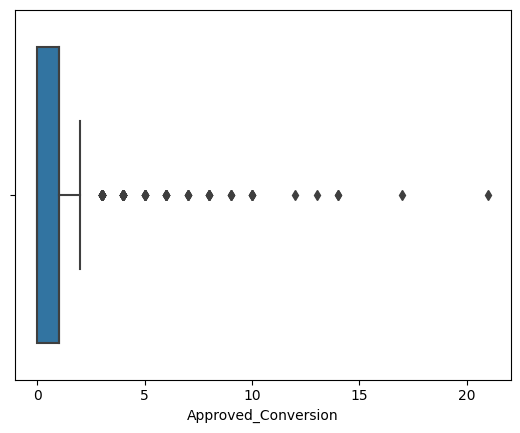

In [13]:
sns.boxplot(x=df.toPandas()["Approved_Conversion"])
df.sort(col("Approved_Conversion").desc()).show()

## Check for constraints violation
We test some constraints that can be inferred from the definition of columns:
- If Spent = 0 then Impressions, Clicks, Total_Conversion, Approved_Conversion = 0
- Approved_Conversion < Total Conversions < Clicks < Impressions

In [14]:
print("Spent=0:")
spark.sql(
    "SELECT count(*) \
            FROM df \
            WHERE Spent = 0 AND (Impressions > 0 OR Clicks > 0 OR Total_Conversion > 0 OR Approved_Conversion > 0)"
).show()

Spent=0:
+--------+
|count(1)|
+--------+
|     207|
+--------+



There are 207 records does not satisfy the first constraints, let's see where it comes from

In [15]:
print("Spent=0 & Impressions>0:")
spark.sql(
    "SELECT count(*) \
            FROM df \
            WHERE Spent = 0 AND (Impressions > 0)"
).show()

Spent=0 & Impressions>0:
+--------+
|count(1)|
+--------+
|     207|
+--------+



In [16]:
print("Spent=0 & Clicks>0:")
spark.sql(
    "SELECT count(*) \
            FROM df \
            WHERE Spent = 0 AND (Clicks > 0)"
).show()

Spent=0 & Clicks>0:
+--------+
|count(1)|
+--------+
|       0|
+--------+



In [17]:
print("Spent=0 & Total_Conversion>0:")
spark.sql(
    "SELECT count(*) \
            FROM df \
            WHERE Spent = 0 AND (Total_Conversion > 0)"
).show()

Spent=0 & Total_Conversion>0:
+--------+
|count(1)|
+--------+
|     204|
+--------+



In [18]:
print("Spent=0 & Approved_Conversion>0:")
spark.sql(
    "SELECT count(*) \
            FROM df \
            WHERE Spent = 0 AND (Approved_Conversion > 0)"
).show()

Spent=0 & Approved_Conversion>0:
+--------+
|count(1)|
+--------+
|      71|
+--------+



The contraints violation mostly comes from the Impression. In practice, we thought of this as the cases that the auto-recommender system of facebook recommend the ads for users that have the same taste with the targeted users, or the friend lists of the targeted users.

In [19]:
print("Clicks > Impressions:")
spark.sql(
    "SELECT COUNT(*) \
            FROM df \
            WHERE Clicks > Impressions"
).show()

Clicks > Impressions:
+--------+
|count(1)|
+--------+
|       0|
+--------+



In [20]:
print("Total_Conversion > Clicks:")
spark.sql(
    "SELECT COUNT(*) \
            FROM df \
            WHERE Total_Conversion > Clicks"
).show()

Total_Conversion > Clicks:
+--------+
|count(1)|
+--------+
|     218|
+--------+



In [21]:
print("Approved_Conversion > Clicks:")
spark.sql(
    "SELECT COUNT(*) \
            FROM df \
            WHERE Approved_Conversion > Clicks"
).show()

Approved_Conversion > Clicks:
+--------+
|count(1)|
+--------+
|      72|
+--------+



print("Total_Conversion > Impressions:")
spark.sql("SELECT COUNT(*) \
            FROM df \
            WHERE Total_Conversion > Impressions").show()

In [22]:
print("Approved_Conversion > Impressions")
spark.sql(
    "SELECT COUNT(*) \
            FROM df \
            WHERE Approved_Conversion > Impressions"
).show()

Approved_Conversion > Impressions
+--------+
|count(1)|
+--------+
|       0|
+--------+



In [23]:
print("Approved_Conversion > Total_Conversion:")
spark.sql(
    "SELECT * \
            FROM df \
            WHERE Approved_Conversion > Total_Conversion"
).show()

Approved_Conversion > Total_Conversion:
+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+
|ad_id|xyz_campaign_id|fb_campaign_id|age|gender|interest|Impressions|Clicks|Spent|Total_Conversion|Approved_Conversion|
+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+
+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+



Also, there are some none-clicked ads but still have conversions. We can see that not all enquiries/sales comes from the ads.

# 2. Stop the Spark Session

In [24]:
spark.stop()